Poems analysis
----

In this notebook we will use Minisom to cluster poems from three different authors.

Requirements:
- Glove vectors, https://nlp.stanford.edu/projects/glove/ glove.6B.50d.txt
- Beautiful soup
- An internet connection as the poems will be downlaoded from www.poemhunter.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Retrieving the poems from poemhunter.com
----

***Warning***: this may take a while.

In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

#-------------------------------------------------------------------------------

def scrape_poem(poem_url):
    poem_page = urlopen(poem_url).read()
    soup = BeautifulSoup(poem_page)
    poem = ''
    poem_string = soup.find_all("div", 
                                {"class": "KonaBody" })[0].find_all('p')[0]
    poem_string = str(poem_string)[3:-4].replace('<br/>', ' ')
    return poem_string

def scrape_poems_index(poems_index_url):
    poems_index = urlopen(poems_index_url).read()    
    soup = BeautifulSoup(poems_index)
    pages = soup.find_all("div", {"class": "pgbluev1"})
    if len(pages) == 0:
        return get_all_links(soup)
    
    pages = pages[0].find_all('a')
    
    result = {}
    cnt = 0
    for page in pages:
        page_link = 'https://www.poemhunter.com/'+page['href']
        page_soup = BeautifulSoup(urlopen(page_link))
        result.update(get_all_links(page_soup))
    return result

def get_all_links(page_soup):
    result = {}    
    for link in page_soup.find_all("p", {"class": "cl333"}):
        link = link.find_all('a')[0]
        result[link['title']] = 'https://www.poemhunter.com/'+link['href']
    return result

def get_poems(poems_index, max_poems=None):
    poems = {}
    for i, (title, poem_url) in enumerate(poems_index.items()):
        print('fetching', title, '...')
        try:
            poems[title] = scrape_poem(poem_url)
            print('OK')
        except:
            print('impossible to fetch')
        if i == max_poems-1:
            return poems
    return poems

In [3]:
poems_index_neruda = scrape_poems_index('https://www.poemhunter.com/pablo-neruda/poems/')
poems_index_bukowski = scrape_poems_index('https://www.poemhunter.com/charles-bukowski/poems/')
poems_index_poe = scrape_poems_index('https://www.poemhunter.com/edgar-allan-poe/poems/')

In [4]:
poems_neruda = get_poems(poems_index_neruda, max_poems=60)
poems_bukowski = get_poems(poems_index_bukowski, max_poems=60)
poems_poe = get_poems(poems_index_poe, max_poems=60)

fetching Still Another Day: XVII/Men poem ...
OK
fetching Still Another Day: I poem ...
OK
fetching Ode to Hope poem ...
OK
fetching Unity poem ...
OK
fetching Epithalamium poem ...
OK
fetching Ode To Ironing poem ...
OK
fetching Ode To The Cat poem ...
OK
fetching Ode To Age poem ...
OK
fetching The Men poem ...
OK
fetching Lxxxiv From: ‘cien Sonetos De Amor’ poem ...
OK
fetching Come With Me, I Said, And No One Knew (VII) poem ...
OK
fetching The Portrait In The Rock poem ...
OK
fetching Walking Around (Original Spanish) poem ...
OK
fetching Sonnet Xiii:The Light That Rises From Your Feet To Your Hair poem ...
OK
fetching Waltz poem ...
OK
fetching Triangles poem ...
OK
fetching Soneto Xvii poem ...
OK
fetching The Old Women Of The Ocean poem ...
OK
fetching Oda Al Tomate poem ...
OK
fetching Sonnet Ix: There Where The Waves Shatter poem ...
OK
fetching The House Of Odes poem ...
OK
fetching Ode To Clothes poem ...
OK
fetching Lone Gentleman poem ...
OK
fetching Leave Me A Place Unde

In [5]:
all_poems = [poems_neruda, poems_bukowski, poems_poe]
titles = np.concatenate([list(title_list.keys()) for title_list in all_poems])
y = np.concatenate([[i]*len(p) for i, p in enumerate(all_poems)])
all_poems = np.concatenate([list(p.values()) for p in all_poems])

Preprocessing of the poems
---

The following operations are applied:

1. stopwords removal
2. tokenization
3. conversion in Glove vectors

In [6]:
from string import punctuation
import stop_words
stopwords = stop_words.get_stop_words('english')

def tokenize_poem(poem):
    poem = poem.lower().replace('\n', ' ')
    for sign in punctuation:
        poem = poem.replace(sign, '')
    tokens = poem.split()
    tokens = [t for t in tokens if t not in stopwords and t != '']
    return tokens

tokenized_poems = [tokenize_poem(poem) for poem in all_poems]

In [7]:
def gimme_glove():
    with open('glove.6B/glove.6B.50d.txt', encoding='utf-8') as glove_raw:
        for line in glove_raw.readlines():
            splitted = line.split(' ')
            yield splitted[0], np.array(splitted[1:], dtype=np.float)
            
glove = {w: x for w, x in gimme_glove()}

def closest_word(in_vector, top_n=1):
    vectors = glove.values()
    idx = np.argsort([np.linalg.norm(vec-in_vector) for vec in vectors])
    return [glove.keys()[i] for i in idx[:top_n]]

In [8]:
def poem_to_vec(tokens):
    words = [w for w in np.unique(tokens) if w in glove]
    return np.array([glove[w] for w in words])

W = [poem_to_vec(tokenized).mean(axis=0) for tokenized in tokenized_poems]
W = np.array(W)

Running minisom and visualizing the result
----
***Warning***: This may take a while.

In [9]:
from minisom import MiniSom
map_dim = 16
som = MiniSom(map_dim, map_dim, 50, sigma=1.0, random_seed=1)
#som.random_weights_init(W)
som.train_batch(W, num_iteration=len(W)*500, verbose=True)

 [ 90000 / 90000 ] 100% - 0:00:00 left 
 quantization error: 0.28209285828168446


In [10]:
author_to_color = {0: 'chocolate', # neruda
                   1: 'steelblue', # bukowski
                   2: 'dimgray'}   # poe 
color = [author_to_color[yy] for yy in y]

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=author_to_color[0], edgecolor='white',label='neruda'),
                   Patch(facecolor=author_to_color[1], edgecolor='white',label='bukowski'),
                   Patch(facecolor=author_to_color[2], edgecolor='white',label='poe'),]

[]

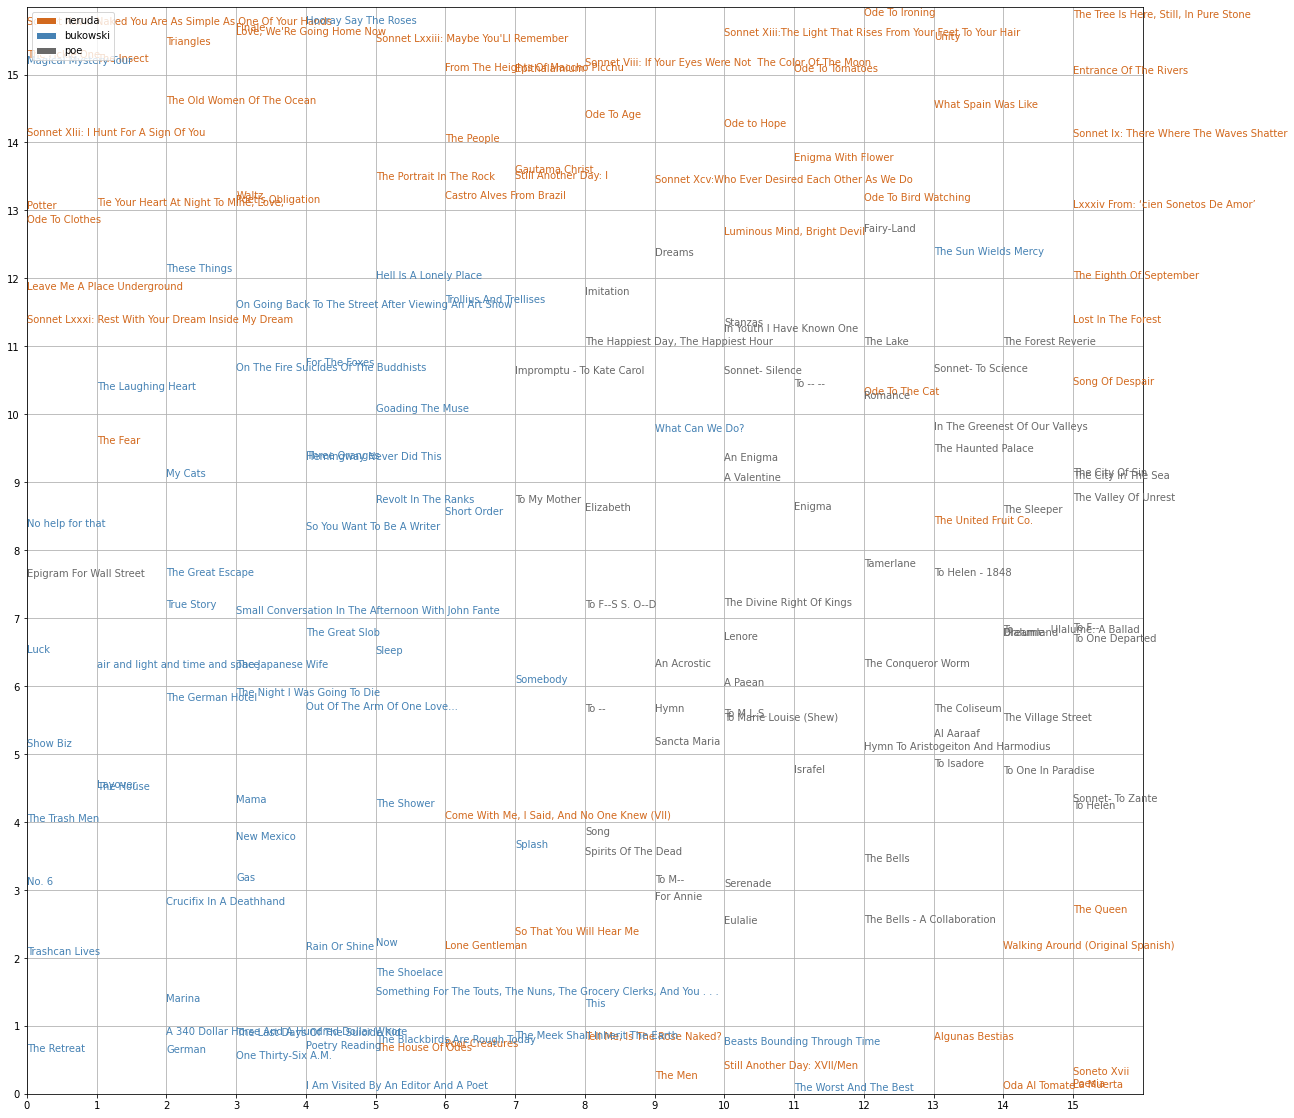

In [11]:
plt.figure(figsize=(20, 20))
texts = []
for i, (t, c, vec) in enumerate(zip(titles, color, W)):
    winnin_position = som.winner(vec)
    texts.append(plt.text(winnin_position[0], 
                 winnin_position[1]+np.random.rand()*.9, 
                 t[:-5],
                 color=c))

plt.legend(handles=legend_elements, loc='upper left')
plt.xticks(range(map_dim))
plt.yticks(range(map_dim))
plt.grid()
plt.xlim([0, map_dim])
plt.ylim([0, map_dim])
plt.plot()